#### Trabajo Práctico 2 : Críticas Cinematográficas

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

# Setup

In [6]:
!pip install -r ./requirements.txt

### Cargar bibliotecas

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
import joblib
from sklearn import metrics
import plotly as py
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from pysentimiento import create_analyzer
import transformers

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Cargar dataset

In [161]:
ds = pd.read_csv("datasets/train.csv")
print(ds.head())

   ID                                          review_es sentimiento
0   0  Uno de los otros críticos ha mencionado que de...    positivo
1   1  Una pequeña pequeña producción.La técnica de f...    positivo
2   2  Pensé que esta era una manera maravillosa de p...    positivo
3   3  Básicamente, hay una familia donde un niño peq...    negativo
4   4  El "amor en el tiempo" de Petter Mattei es una...    positivo


# Visualización de los datos

In [162]:
x = ds['sentimiento'].value_counts()
fig = py.graph_objs.Figure([py.graph_objs.Bar(x=x.index, y=x.values)])
fig.update_layout(title_text='Distribución de tweets reales y falsos')
fig.show()

Observamos el gráfico y confirmamos que es un data set balanceado. No hará falta hacer over o undersampling.

# Preprocesamiento de datos

In [81]:
reviews = ds["review_es"]
sentiments = [1 if sentiment == "positivo" else 0 for sentiment in ds["sentimiento"]]

In [163]:
vectorizador = CountVectorizer()
reviews_vectorized = vectorizador.fit_transform(reviews)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(reviews_vectorized, sentiments, test_size=0.2, random_state=42)

In [165]:
print(sum(y_train) / len(y_train))

0.499025


# Entrenamiento de modelos

## Bernoulli

In [38]:
nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)
joblib.dump(svm_classifier, f"models/bernoulli.pkl")

['models/bernoulli.pkl']

In [39]:
y_pred = nb_model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8466
Precision: 0.8670157068062827
Recall: 0.8215915856320699
F1 Score: 0.8436926839209293


In [10]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = nb_model.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/binomialNB.csv", index=False)

In [17]:
param_grid = {
    "alpha": [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    "binarize": [0.0, 0.5, 1.0, 2.0, 5.0, 10.0],
    "fit_prior": [True, False]
}

nb_model = BernoulliNB()
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, sentiments)

print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'alpha': 0.5, 'binarize': 0.0, 'fit_prior': True}


In [15]:
best_params = {'alpha': 0.5, 'binarize': 0.0, 'fit_prior': True}

In [16]:
nb_model = BernoulliNB(**best_params)
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8458
Precision: 0.8641949593834618
Recall: 0.8233776542964873
F1 Score: 0.8432926829268294


In [17]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = nb_model.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/binomialNB_best.csv", index=False)

## Pysentimiento

In [22]:
transformers.logging.set_verbosity(transformers.logging.ERROR)
analyzer = create_analyzer(task="sentiment", lang="es")

In [23]:
prediction = analyzer.predict(reviews[0])

print("positivo" if prediction.probas["POS"] > prediction.probas["NEG"] else "negativo")

negativo


In [24]:
test_ds = pd.read_csv("datasets/test.csv")
reviews = test_ds["review_es"].tolist()
for i in range(len(reviews)):
    prediction = analyzer.predict(reviews[i])
    test_ds.loc[i, "sentimiento"] = "positivo" if prediction.probas["POS"] > prediction.probas["NEG"] else "negativo"

test_ds[["ID","sentimiento"]].to_csv("submissions/pysentimiento.csv", index=False)


## Random Forest

In [17]:
#Random forest

FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = { 
    'n_estimators': [10, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfc = RandomForestClassifier(random_state=42)

gs = RandomizedSearchCV(rfc, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
gs.fit(X_train, sentiments)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 200, 300,
                                                         500]},
                   scoring=make_scorer(f1_score, zero_division=1), verbose=2)

In [19]:
print(gs.best_params_)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}


In [36]:
best_params = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}

rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)
joblib.dump(svm_classifier, f"models/randomforest.pkl")

['models/randomforest.pkl']

In [28]:
y_pred = rfc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8261
Precision: 0.810267017675818
Recall: 0.8551299861083548
F1 Score: 0.8320942357825625


In [30]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = rfc.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/randomforest.csv", index=False)

## XGBoost

In [15]:
# XGBoost
from xgboost import XGBClassifier

FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

hiperparametros = {
    'n_estimators': [10, 100, 200, 300, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

xgb = XGBClassifier(random_state=42)

gs = RandomizedSearchCV(xgb, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=100)
gs.fit(X_train, sentiments)

print(gs.best_params_)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time= 8.8min
[CV] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total time= 7.6min
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.6; total time=15.4min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=300, subsample=0.9; total time= 7.5min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.6; total time=13.0min
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=500, subsample=0.6; total time=16.0min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05,

In [17]:
from xgboost import XGBClassifier

best_params = {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.7}
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

# Save best XGBoost
joblib.dump(xgb, f"models/xgboost.pkl")

y_pred = xgb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8722
Precision: 0.8643673706645999
Recall: 0.8852947013296288
F1 Score: 0.8747058823529412


In [18]:
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = xgb.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/xgboost.csv", index=False)

## SVM

In [14]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_classifiers = {}

for kernel in kernels:
    # Create an SVM classifier with the current kernel
    svm_classifier = svm.SVC(kernel=kernel)

    # Train the classifier on the training data
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the model
    print(sklearn.metrics.classification_report(y_test, y_pred))
    svm_classifiers[kernel] = svm_classifier

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      4961
           1       0.82      0.90      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4961
           1       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

              preci

In [17]:
# Guardamos los modelos entrenados

for kernel, svm_classifier in svm_classifiers.items():
    joblib.dump(svm_classifier, f"models/svm_classifier_{kernel}.pkl")

In [ ]:
test_ds = pd.read_csv("datasets/test.csv")
for classfier in svm_classifiers:
    test_ds["sentimiento"] = svm_classifiers[classfier].predict(vectorizador.transform(test_ds["review_es"]))
    # convert "sentimiento" to "positivo" or "negativo"
    test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
    test_ds[["ID","sentimiento"]].to_csv("submissions/svm_" + classfier + ".csv", index=False)

Observamos que el mejor fue el Radial Basis Function kernel, por lo que vamos a buscar hiperparámetros para ver si podemos mejorar ese.

In [19]:
# Observamos que el mejor fue el Radial Basis Function kernel, por lo que vamos a buscar hiperparámetros para ver si podemos mejorar ese.

FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score)

hiperparametros = {
    'C': [0.01, 0.1, 1, 2],
    'gamma': ["auto", "scale"],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5]
}

svm_classifier = svm.SVC()

gs = RandomizedSearchCV(svm_classifier, hiperparametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, verbose=2, n_iter=10)
gs.fit(X_train, sentiments)

print(gs.best_params_)

ValueError: Found input variables with inconsistent numbers of samples: [40000, 50000]

In [31]:
best_params = {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 1}
# Create the best SVM classfier
svm_classifier = svm.SVC(**best_params)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Save best SVM
joblib.dump(svm_classifier, f"models/svm_classifier_{best_params['kernel']}_best.pkl")

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8641
Precision: 0.8494113178883403
Recall: 0.887676126215519
F1 Score: 0.8681222707423581


In [33]:
# Make Kaggle predictions
test_ds = pd.read_csv("datasets/test.csv")
test_ds["sentimiento"] = svm_classifier.predict(vectorizador.transform(test_ds["review_es"]))
# convert "sentimiento" to "positivo" or "negativo"
test_ds["sentimiento"] = test_ds["sentimiento"].apply(lambda x: "positivo" if x == 1 else "negativo")
test_ds[["ID","sentimiento"]].to_csv("submissions/svm_rbf_best.csv", index=False)

## Redes Neuronales

In [201]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping

cant_clases = len(np.unique(y_train))
d_in = X_train.shape[1]

# early_stopping = EarlyStopping(
#     monitor='loss',
#     patience=3,
#     restore_best_weights=True,
# )

modelo = keras.Sequential([
    keras.layers.Dense(2,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(1, activation='relu')])

# modelo = keras.Sequential([
#     keras.layers.Dense(64, input_shape=(d_in,), activation='relu'),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(1, activation='relu')
# ])


modelo.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 2)                 351708    
                                                                 
 dense_59 (Dense)            (None, 1)                 3         
                                                                 
Total params: 351,711
Trainable params: 351,711
Non-trainable params: 0
_________________________________________________________________


In [202]:
X_train.shape

(40000, 175853)

In [180]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [186]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [203]:
modelo.compile(
  #optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
  optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), #mas optima
  loss='binary_crossentropy', 
  metrics=['AUC'], #metrica de area bajo la curva 
)

cant_epochs=50
historia_modelo = modelo.fit(
    X_train,
    y_train,
    epochs=cant_epochs,
    batch_size=32,
    verbose=False,
    #callbacks=[early_stopping],
    )

In [204]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



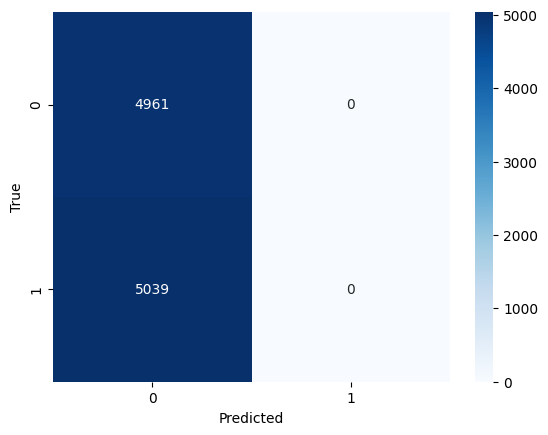

In [207]:
metricas(y_pred, y_test)

In [206]:

y_pred = modelo.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))



  1/313 [..............................] - ETA: 6s

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.4961
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

